**Prereqs**

List all the modules needed to run the below notebook.

Authors:
Project Description:
Who built what?
Analysis

**Import Modules**

In [193]:
import pandas as pd
import sqlite3
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import plotly.express as px
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

**Read in the wildfire dataset and display columns**

- Download dataset from https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data
- unzip into /data directory

In [194]:
# # extract the zipped dataset
with zipfile.ZipFile('./data/archive.zip', 'r') as zipped:
    zipped.extractall('./data/')

In [195]:
# connect to the sqlite database
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')

In [196]:
tables = pd.read_sql_query(
    """
    SELECT name FROM sqlite_master WHERE type='table'
    """
    , conn)

In [197]:
# Print out the table names
tables

,name
0,spatial_ref_sys
1,spatialite_history
2,sqlite_sequence
3,geometry_columns
4,spatial_ref_sys_aux
5,views_geometry_columns
6,virts_geometry_columns
7,geometry_columns_statistics
8,views_geometry_columns_statistics
9,virts_geometry_columns_statistics


**Utilizing Fires Table**

In [198]:
# read in the fires table
wildfireDf = pd.read_sql_query(
    """
    SELECT * 
    FROM fires
    """
    , conn)

**Exploratory Data Analysis**
Display the first 5 rows

In [199]:
wildfireDf.head(5)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [200]:
# Describe the dataset
# wildfireDf.describe
# wildfireAnalysisDf.columns

In [201]:
#dropping duplicates
wildfireAnalysisDf = wildfireDf.drop_duplicates()

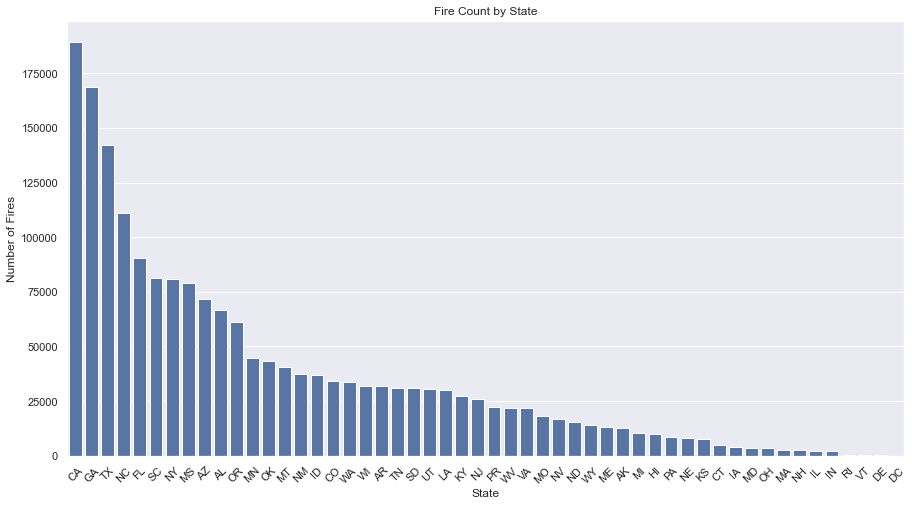

In [203]:
#TODO: Rajeev
#Visualize fire count by state

# Assuming wildfireAnalysisDf is your DataFrame
fire_count_by_state = wildfireAnalysisDf.groupby('STATE').size().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x=fire_count_by_state.index, y=fire_count_by_state.values)
plt.xlabel('State')
plt.ylabel('Number of Fires')
plt.title('Fire Count by State')
plt.xticks(rotation=45)
plt.show()

In [204]:
# Find wildfire count by county
countyDf = wildfireAnalysisDf.groupby("STATE").size().to_frame('Count').sort_values(by=["Count"], ascending=False).reset_index()
countyDf.head()

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


fig = px.choropleth(countyDf, locations='STATE', color='Count',
    locationmode="USA-states",
    color_continuous_scale="Reds",
    scope="usa",
    labels={'Count':'Wildfire Count'},
    title="Wildfire Count By State"
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

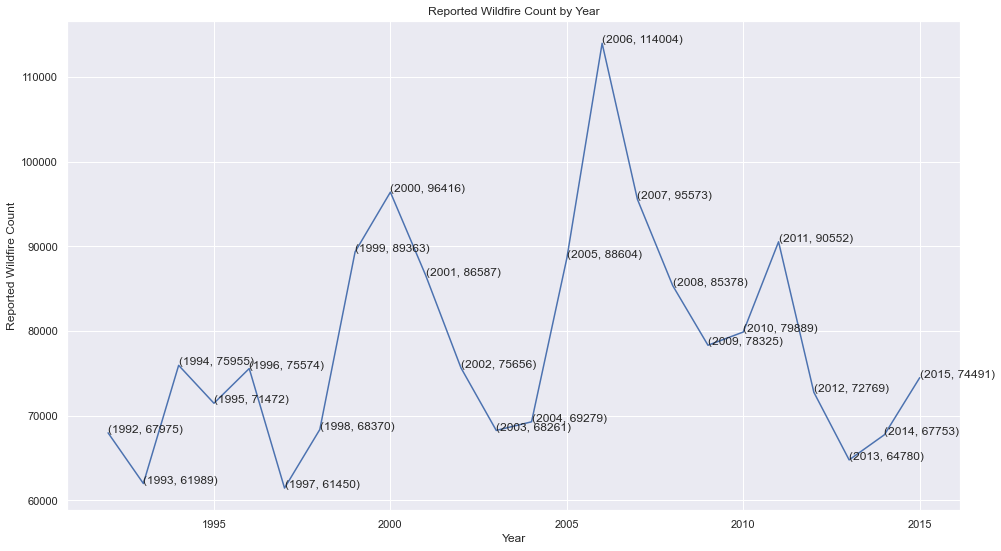

In [206]:
#TODO: Connor
#Visualize fire count over time
firesOverTimeDf = wildfireAnalysisDf.groupby("FIRE_YEAR").size().to_frame('Count').reset_index()
# create plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.plot(firesOverTimeDf["FIRE_YEAR"],firesOverTimeDf["Count"])
plt.xlabel("Year")
plt.ylabel("Reported Wildfire Count")
plt.title("Reported Wildfire Count by Year")
# add annotation to points
for (i, j) in zip(firesOverTimeDf["FIRE_YEAR"],firesOverTimeDf["Count"]):
    plt.text(i, j, f'({i}, {j})')

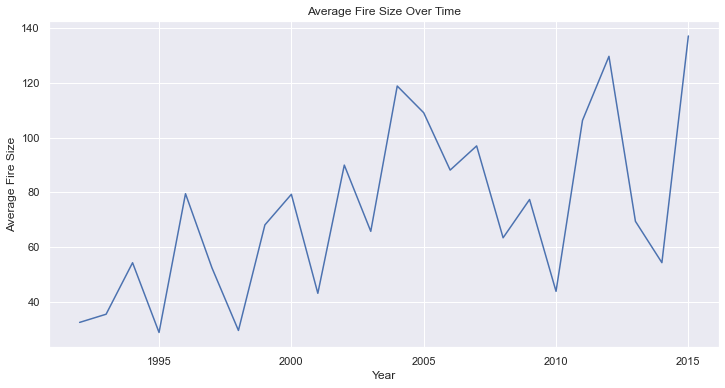

In [207]:
#TODO: Naveen
#Visualize avg fire size over time

# Assuming 'wildfireAnalysisDf' is your DataFrame containing the wildfire data.

# Group the data by 'FIRE_YEAR' and calculate the average fire size for each year
avg_fire_size_per_year = wildfireAnalysisDf.groupby('FIRE_YEAR')['FIRE_SIZE'].mean()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_fire_size_per_year.index, y=avg_fire_size_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Fire Size')
plt.title('Average Fire Size Over Time')

# Display the plot
plt.show()

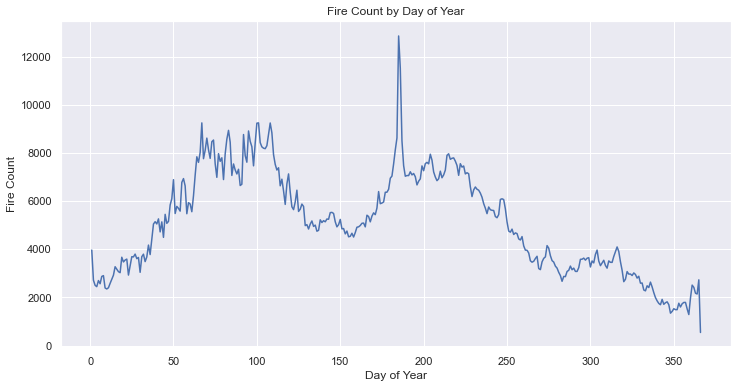

In [208]:
#TODO: Rajeev
#Plot fire count by DISCOVERY_DOY, or DISCOVERY_DATE

# For plotting fire count by DISCOVERY_DOY
fire_count_by_doy = wildfireAnalysisDf.groupby('DISCOVERY_DOY').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=fire_count_by_doy.index, y=fire_count_by_doy.values)
plt.xlabel('Day of Year')
plt.ylabel('Fire Count')
plt.title('Fire Count by Day of Year')
plt.show()

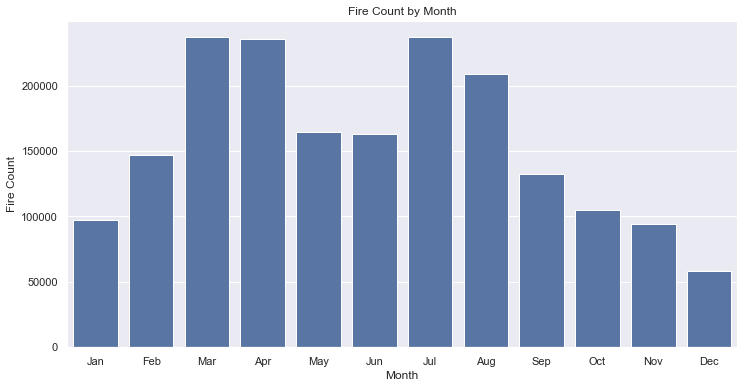

In [209]:
#Rajeev
# This script first converts the day of the year to the corresponding month
# and then plots the count of fires per month. The plot will provide a clear view of the monthly distribution of wildfire occurrences.


# Function to convert day of the year to month
def doy_to_month(doy):
    # Using a non-leap year for conversion (e.g., 2021)
    date = datetime.strptime(f'2021-{doy}', '%Y-%j')
    return date.strftime('%b')  # %b gives the abbreviated month name

# Apply the conversion to the DISCOVERY_DOY column
wildfireAnalysisDf['DISCOVERY_MONTH'] = wildfireAnalysisDf['DISCOVERY_DOY'].apply(doy_to_month)

# Group by the new DISCOVERY_MONTH column and count the fires
fire_count_by_month = wildfireAnalysisDf.groupby('DISCOVERY_MONTH').size()

# Ordering the months correctly
months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fire_count_by_month = fire_count_by_month.reindex(months_order)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x=fire_count_by_month.index, y=fire_count_by_month.values)
plt.xlabel('Month')
plt.ylabel('Fire Count')
plt.title('Fire Count by Month')
plt.show()

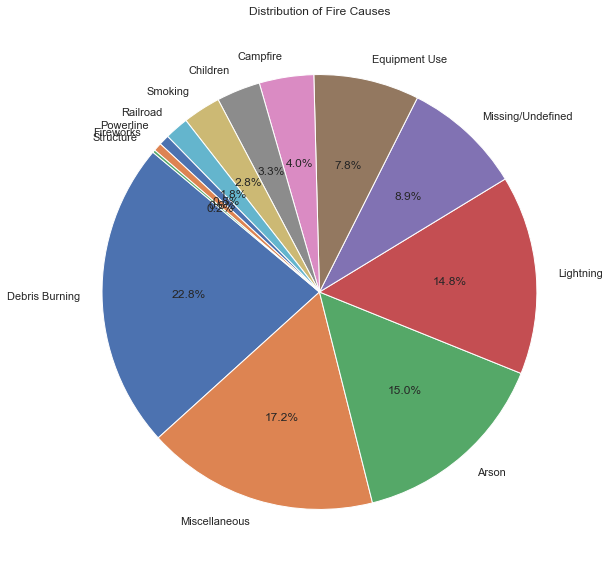

In [210]:
#TODO: Rajeev
# Fire Causes Distribution
fire_causes = wildfireAnalysisDf['STAT_CAUSE_DESCR'].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(fire_causes, labels=fire_causes.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Fire Causes')
plt.show()

In [211]:
#TODO: Naveen
#Create a new column of duration of fire (CONT_DOY-DISCOVERY_DOY)
# Assuming 'CONT_DOY' and 'DISCOVERY_DOY' are columns in your DataFrame
wildfireAnalysisDf['FIRE_DURATION'] = wildfireAnalysisDf['CONT_DOY'] - wildfireAnalysisDf['DISCOVERY_DOY']

# Handle cases where the fire spans over the new year
wildfireAnalysisDf['FIRE_DURATION'] = wildfireAnalysisDf['FIRE_DURATION'].apply(lambda x: x if x >= 0 else x + 365)

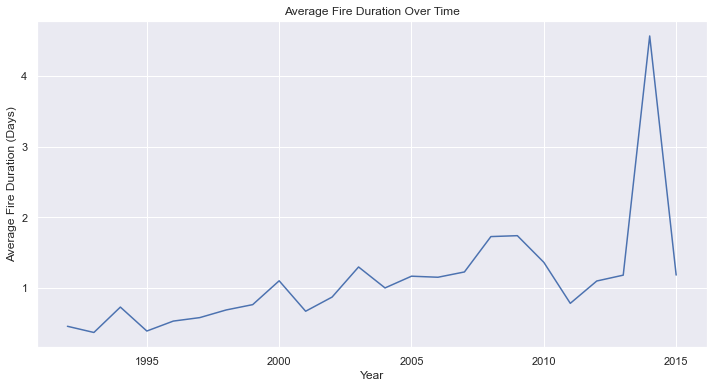

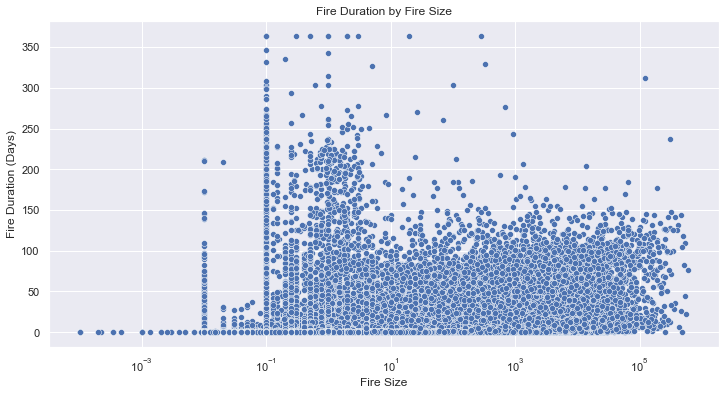

In [212]:
#TODO: Naveen
#Plot Duration by time
#Plot duration by Fire_Size


# Group by FIRE_YEAR and calculate the average fire duration for each year
avg_duration_per_year = wildfireAnalysisDf.groupby('FIRE_YEAR')['FIRE_DURATION'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_duration_per_year.index, y=avg_duration_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average Fire Duration (Days)')
plt.title('Average Fire Duration Over Time')
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x='FIRE_SIZE', y='FIRE_DURATION', data=wildfireAnalysisDf)
plt.xlabel('Fire Size')
plt.ylabel('Fire Duration (Days)')
plt.title('Fire Duration by Fire Size')
plt.xscale('log')  # Optional: Use logarithmic scale if fire sizes vary widely
plt.show()

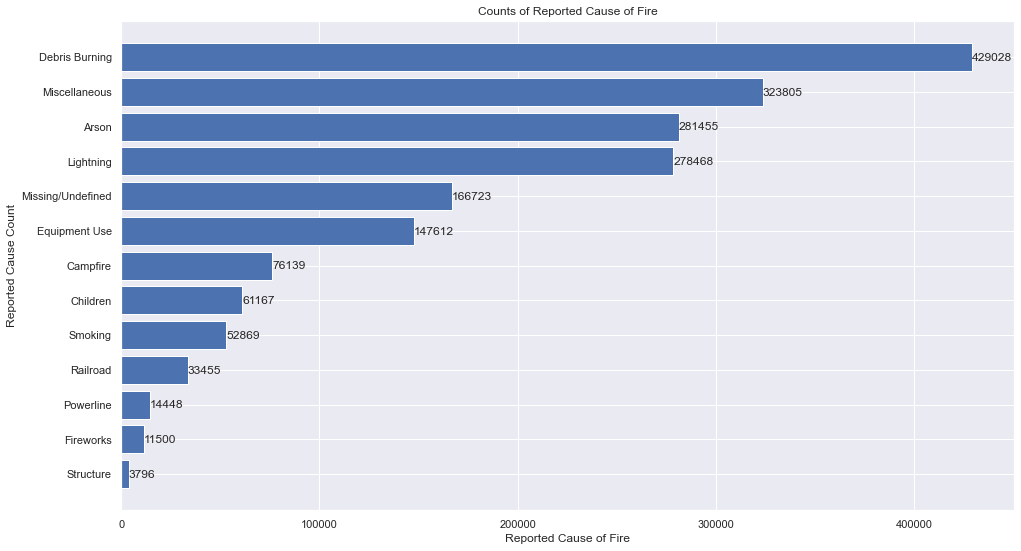

In [213]:
#TODO: Connor
#Visualize fire count by STAT_CAUSE_CODE/desc (cause), label with description
fireCausesDf = wildfireAnalysisDf.groupby("STAT_CAUSE_DESCR").size().to_frame('Count').sort_values(by=["Count"], ascending=False).reset_index()
# create plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(fireCausesDf["STAT_CAUSE_DESCR"],fireCausesDf["Count"])
# add title and labels
plt.xlabel("Reported Cause of Fire")
plt.ylabel("Reported Cause Count")
plt.title("Counts of Reported Cause of Fire")
# invert order so highest first
plt.gca().invert_yaxis()
# add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
        str(round((i.get_width()), 2)))

In [214]:
# Naveen - Logistic Regression
# Objective: Train a logistic regression model to predict the cause of the fire (categorical variable STAT_CAUSE_DESCR).

# Data Preprocessing:

# Handle missing values in relevant columns.
# Convert categorical variables to dummy variables (One-Hot Encoding) as needed.
# Split the data into features (X) and target (y) where y is STAT_CAUSE_DESCR.
# Model Training and Validation:

# Split the dataset into training and testing sets.
# Train a logistic regression model on the training set.
# Validate the model on the testing set using appropriate metrics (accuracy, confusion matrix, etc.).
# Feature Selection and Tuning:

# Use techniques like backward elimination or regularization to select significant features.
# Tune hyperparameters of the logistic regression model for better performance if necessary.

In [215]:
import pandas as pd

# Creating a copy of the DataFrame
wildfire_df_copy = wildfireAnalysisDf.copy()

# Selecting relevant columns
relevant_columns = ['FIRE_YEAR', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'STATE', 'DISCOVERY_MONTH', 'FIRE_DURATION', 'STAT_CAUSE_DESCR']
wildfire_df_selected = wildfire_df_copy[relevant_columns]


In [216]:

# Handling missing values
wildfire_df_selected = wildfire_df_selected.dropna()

# Converting categorical variables to dummy variables
wildfire_df_processed = pd.get_dummies(wildfire_df_selected, columns=['OWNER_CODE', 'STATE', 'DISCOVERY_MONTH'])


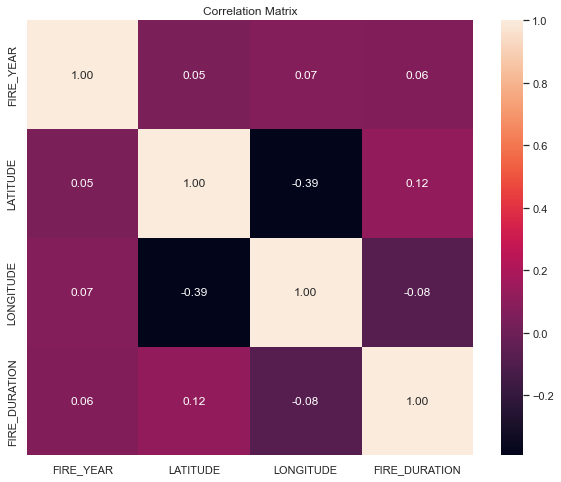

In [217]:
# Exclude non-numeric columns for correlation calculation
import numpy as np
numeric_df = wildfire_df_processed.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric columns only
corr_matrix = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [218]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = wildfire_df_processed.drop('STAT_CAUSE_DESCR', axis=1)
y = wildfire_df_processed['STAT_CAUSE_DESCR']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


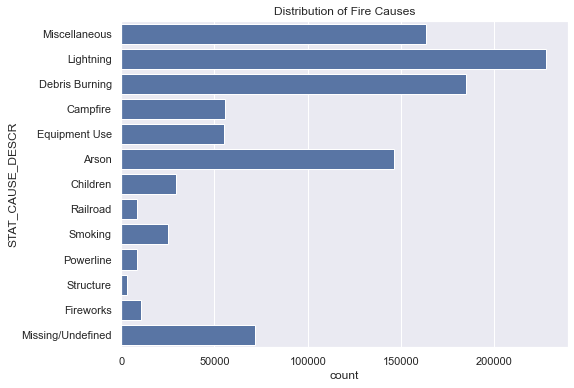

In [219]:
# Visualize the distribution of target variable
sns.countplot(y)
plt.title("Distribution of Fire Causes")
plt.show()


In [220]:
# Randomly sample a subset of your data, for example, 10% of it
sampled_df = wildfire_df_processed.sample(frac=0.1, random_state=42)

# Split the sampled data into features and target
X_sampled = sampled_df.drop('STAT_CAUSE_DESCR', axis=1)
y_sampled = sampled_df['STAT_CAUSE_DESCR']

# Split into training and testing sets
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)


In [221]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the training and testing sets
X_train_scaled = scaler.fit_transform(X_train_sampled)
X_test_scaled = scaler.transform(X_test_sampled)


In [222]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model with a higher number of iterations
logistic_model_sampled = LogisticRegression(max_iter=2000)

# Fit the model on the scaled training data
logistic_model_sampled.fit(X_train_scaled, y_train_sampled)


LogisticRegression(max_iter=2000)

Accuracy on Scaled Test Data: 0.5309761359040043


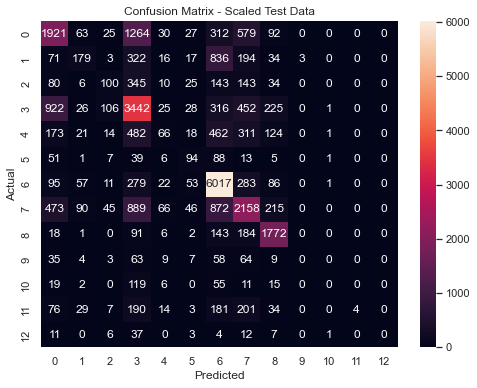

In [224]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the scaled test data
y_pred_sampled = logistic_model_sampled.predict(X_test_scaled)

# Evaluate the model
accuracy_sampled = accuracy_score(y_test_sampled, y_pred_sampled)
conf_matrix_sampled = confusion_matrix(y_test_sampled, y_pred_sampled)

# Display the accuracy and confusion matrix
print(f"Accuracy on Scaled Test Data: {accuracy_sampled}")
sns.heatmap(conf_matrix_sampled, annot=True, fmt="g")
plt.title("Confusion Matrix - Scaled Test Data")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Linear Regression Preprocessing

In [225]:

# Connor - Linear Regression

# Objective: Train a linear regression model to predict the size of a wildfire (continuous variable FIRE_SIZE).

# Data Preprocessing:

# Address any missing or outlier values in FIRE_SIZE and other relevant features.
TARGET = "FIRE_SIZE"
SEED = 42
wildfireSizeAnalysisDf = wildfireAnalysisDf[["FIRE_SIZE", "FIRE_YEAR", "OWNER_CODE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE", "STATE", "FIRE_DURATION","DISCOVERY_DOY"]]
wildfireSizeAnalysisDf = wildfireSizeAnalysisDf.dropna(axis=0)
wildfireSizeAnalysisDf.drop_duplicates(inplace=True)
wildfireSizeAnalysisDf = wildfireSizeAnalysisDf.astype({"STAT_CAUSE_DESCR":"string", "OWNER_CODE": "string"})
numericalFeatures = wildfireSizeAnalysisDf[["FIRE_SIZE","FIRE_YEAR", "LATITUDE", "LONGITUDE", "FIRE_DURATION", "DISCOVERY_DOY"]]




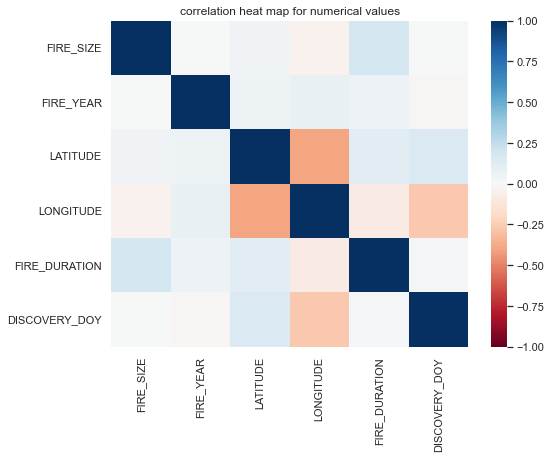

In [226]:
# Look at the correlation matrix
corr_mat = numericalFeatures.corr()
plt.title("correlation heat map for numerical values")
sns.set(rc={'figure.figsize':(8,6)})
s = sns.heatmap(corr_mat,cmap="RdBu",center=0,vmin=-1, vmax=1)

Linear Regression

In [227]:
# Let's try a model with only numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(numericalFeatures.drop(columns=[TARGET]),numericalFeatures[TARGET],test_size=.2,random_state=SEED)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a linear regression model on the training set.
linReg = LinearRegression()
linReg.fit(X_train, y_train)

yPred = linReg.predict(X_test)

# Evaluate the model's performance using metrics like R-squared, RMSE (Root Mean Squared Error).
linRegScore = r2_score(y_test,yPred)
linRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {linRegScore} \nRMSE: {linRegRMSE}")
 
# The R2 and RMSE scores are not promising for predicting wildfire size. 
# Let's see if including one-hot encoded variables helps

R2 score: 0.03671182783183813 
RMSE: 9290250.50264381


Text(0.5, 1.0, 'Linear Regression with Numerical Data Only, Predicted vs Actual')

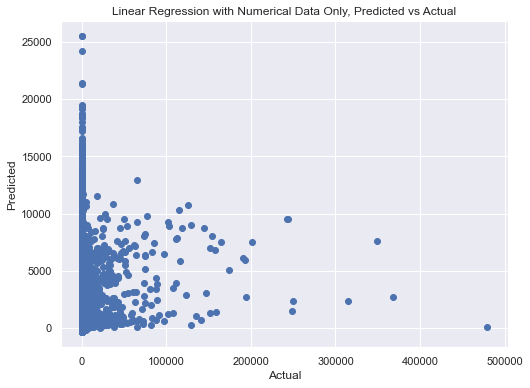

In [228]:
# visualize linear regression ran with numerical data only
plt.scatter(y_test, yPred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression with Numerical Data Only, Predicted vs Actual")
# This is not a very linear relationship, linear or random forest regression is not a choice model for predicting wildfires.

Linear Regression with one-hot encoded categorical features

In [229]:
# Convert categorical data to numerical format using encoding methods.
wildfireSizeAnalysisDf = pd.get_dummies(wildfireSizeAnalysisDf, columns = ["STATE","STAT_CAUSE_DESCR", "OWNER_CODE"])

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(wildfireSizeAnalysisDf.drop(columns=[TARGET]),wildfireSizeAnalysisDf[TARGET],test_size=.2,random_state=SEED)


In [230]:

# Train a linear regression model on the training set.
linReg = LinearRegression()
linReg.fit(X_train, y_train)

yPred = linReg.predict(X_test)

# Evaluate the model's performance using metrics like R-squared, RMSE (Root Mean Squared Error).
linRegScore = r2_score(y_test,yPred)
linRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {linRegScore} \nRMSE: {linRegRMSE}")

# This shows some improvement in test scores, but it is still not promising.


R2 score: 0.04377555475029937 
RMSE: 9222125.724980375


Text(0.5, 1.0, 'Linear Regression Predicted vs Actual')

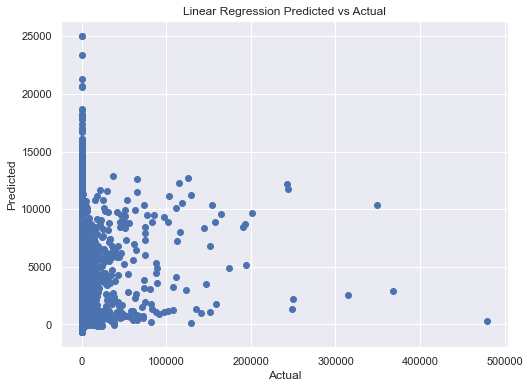

In [231]:
# visualize linear regression test results
plt.scatter(y_test, yPred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression Predicted vs Actual")
# This is not a very linear relationship, linear or random forest regression is not a choice model for predicting wildfires.

Random Forest Regression

In [232]:
#Try random forest regression!
#NOTE expect this cell to run for ~2 minutes!

#limit sample to 10,000 for time's sake
reg_rf = RandomForestRegressor(random_state=42, max_samples=10000)
reg_rf.fit(X_train,y_train)
y_pred = reg_rf.predict(X_test)

rRegScore=r2_score(y_test, y_pred)
rRegRMSE = mean_squared_error(y_test, yPred, squared=True)
print(f"R2 score: {rRegScore} \nRMSE: {rRegRMSE}")

R2 score: 0.13830854316087504 
RMSE: 9222125.724980375


Text(0.5, 1.0, 'Random Forest Regression Predicted vs Actual')

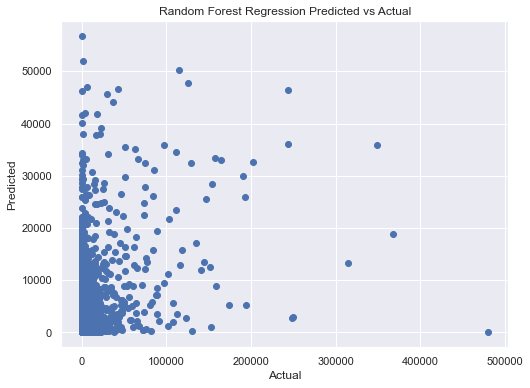

In [233]:
# visualize random forest regression results
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression Predicted vs Actual")
# This shows some improvement over linear regression, however it is still not promising as it is not showing a pattern. Random forest regression is not a choice model for predicting wildfires.

Linear Regression Conclusion:

From the results above, for linear regression we see that linear regression is not sufficient to create a predictive model with the features "FIRE_YEAR", "OWNER_CODE", "STAT_CAUSE_DESCR", "LATITUDE", "LONGITUDE", "STATE", "FIRE_DURATION","DISCOVERY_DOY" to predict "FIRE_SIZE". 

Ultimately, the R2, RMSE scores are too low and Prediction vs. Actual plots show us that this does not make a trustworthy model of predicting fire size. In the Prediction vs. Actual plot we would like to see a direct linear trend with some variation and there is no direct relationship apparent.

Random Forest Regression offered some improvement in model performance. Further increasing the sampling size in random forest did not achieve meaningful increases in model accuracy at the expense of compute resources. Therefore it was deemed not necessary to run a long training with this model. The level of accuracy of this model, seen with the R2, RMSE, and Prediction vs. Actual plot also do not offer promising scores or a direct trend in the graph.

In order to improve model performance, we suggest further feature acquisition, particularly features related to weather. Joining wildfire data by county with weather data such as precipitation and wind speed and direction may improve the performance of this predictive model and offer more useful information.

In [ ]:
# Prepare the dataset by selecting relevant features and the target variable
features_for_pca = ['LONGITUDE', 'LATITUDE', 'FIRE_DURATION', 'OWNER_CODE']
additional_features = ['FIRE_YEAR', 'LATITUDE', 'LONGITUDE']
target_variable = 'FIRE_SIZE'
wildfire_df_full = wildfireAnalysisDf[features_for_pca + additional_features + [target_variable]].dropna()

# Standardizing only the features meant for PCA
scaler = StandardScaler()
wildfire_df_features_scaled = scaler.fit_transform(wildfire_df_full[features_for_pca])


In [ ]:
wildfireAnalysisDf.head(5)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,DISCOVERY_MONTH,FIRE_DURATION
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,Feb,0.0
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,May,0.0
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,Jun,0.0
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,Jun,5.0
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,Jun,5.0


In [ ]:
# Apply PCA to reduce the dimensionality of the selected features
pca = PCA()
wildfire_df_features_pca = pca.fit_transform(wildfire_df_features_scaled)

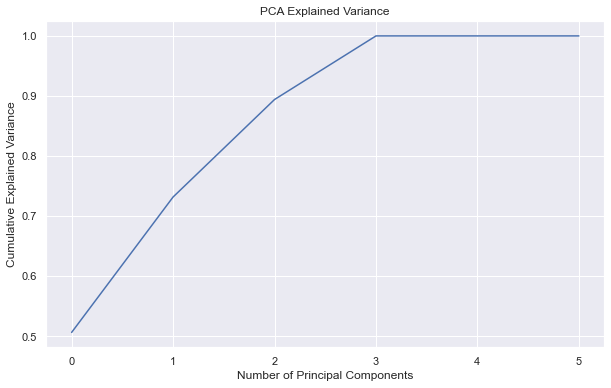

In [ ]:
# Visualize the cumulative explained variance to guide the number of components to retain
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
# Combine the PCA components with the additional features for regression analysis
X_combined = np.hstack((wildfire_df_features_pca, wildfire_df_full[additional_features].values))
y = wildfire_df_full[target_variable]

In [ ]:
# Split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

In [ ]:
# Train a linear regression model to predict FIRE_SIZE
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Extracting the original features from X_test
original_features = X_test[:, -len(additional_features):]  # Assuming the last columns are the original features

# Creating a DataFrame with the original features
test_df = pd.DataFrame(original_features, columns=additional_features)

# Adding actual and predicted fire sizes to the DataFrame
test_df['Actual_FIRE_SIZE'] = y_test
test_df['Predicted_FIRE_SIZE'] = y_pred


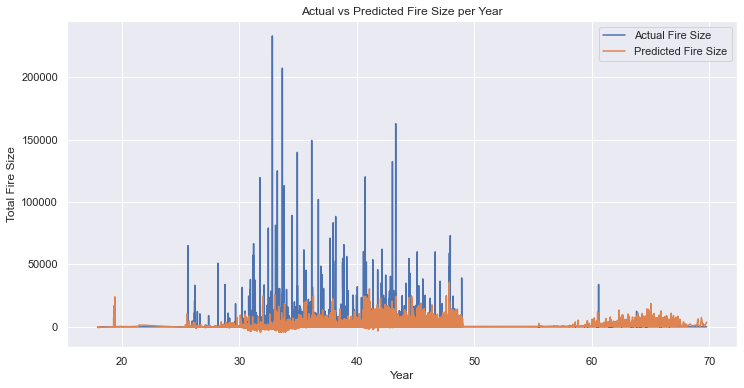

In [ ]:
# Compare actual and predicted fire sizes by year
yearly_comparison = test_df.groupby('FIRE_YEAR').agg({'Actual_FIRE_SIZE': 'sum', 'Predicted_FIRE_SIZE': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_comparison, x='FIRE_YEAR', y='Actual_FIRE_SIZE', label='Actual Fire Size')
sns.lineplot(data=yearly_comparison, x='FIRE_YEAR', y='Predicted_FIRE_SIZE', label='Predicted Fire Size')
plt.title('Actual vs Predicted Fire Size per Year')
plt.ylabel('Total Fire Size')
plt.xlabel('Year')
plt.legend()
plt.show()


In [ ]:
# # Visualizations based on your models. Say 3 visuals for each model
# Naveen - 3 visuals for Logistic Regression
# Connor - 3 visuals for Linear Regression
# Rajeev - 3 visuals for PCA with Models

**PROJECT PLAN**

**Initial Data Assessment**

Data Quality Check: Quickly assess the completeness, accuracy, and consistency of the data.

Missing Values Identification: Identify missing data in each column and analyze the pattern of missingness.

Outliers and Inconsistencies Detection: Use statistical methods and visualizations to detect outliers and data inconsistencies.

Dataset Structure Evaluation: Understand the relationships between different tables and columns in the dataset.

*Data Cleaning*

Handle Missing Values: Decide whether to impute or remove missing data based on its impact.

Correct Anomalies/Outliers: Address outliers and anomalies using appropriate statistical methods.

*Data Transformation*

Normalize/Standardize Variables: Apply scaling to continuous variables for linear regression.

Categorical Variable Conversion: Convert categorical data using encoding methods suitable for logistic regression.

Feature Engineering: Create or transform features to enhance model performance.

*Data Reduction*

Dataset Downsizing: If necessary, use stratified sampling to manage the dataset's size, ensuring it remains representative.

*Efficiency and Scalability*

Optimize Data Processes: Improve the efficiency of data loading and transformation.

Parallel Processing/Cloud Solutions: Consider parallel processing or cloud-based solutions for handling large datasets.

**Exploratory Analysis**
Above visuals (**DONE**)

**Modelling**

*Logistic Regression (Predicting the Cause of the Fire)*
Feature Selection: Identify and select relevant features for the logistic regression model.

Data Splitting: Split the dataset into training and testing sets.

Model Training: Train the logistic regression model on the training set.

Model Validation: Validate the model's performance on the test set using metrics like accuracy, precision, recall, and confusion matrix.

Hyperparameter Tuning: Tune the model parameters for better performance, if necessary.

Model Interpretation: Interpret the model coefficients to understand the influence of various features.

*Linear Regression (Predicting the Size of the Wildfire)*
Feature Selection and Preparation: Choose relevant features for the linear regression model and ensure they meet the assumptions of linear regression.

Data Splitting: Divide the data into training and test subsets.

Model Training: Fit the linear regression model on the training data.

Model Evaluation: Assess the model on the testing data using metrics like R-squared and RMSE (Root Mean Squared Error).

Assumption Validation: Check for linear regression assumptions like linearity, homoscedasticity, and normality of residuals.

Adjustments and Refinements: Make necessary adjustments based on model diagnostics and retrain the model if needed.

*PCA (Principal Component Analysis) - Optional*
Standardization: Standardize the dataset before applying PCA.

PCA Application: Apply PCA to reduce dimensions and select the number of principal components.

Model Integration: Use PCA components as features in both logistic and linear regression models.

Model Training and Evaluation: Train and evaluate the models using the principal components and compare the performance with non-PCA models.

**Post-Modeling Visualization and Analysis**

*Model Performance Metrics Visualization:*

Create charts to visually represent model accuracy, confusion matrices, ROC curves for logistic regression, and residual plots for linear regression.
Use bar charts or line graphs to display R-squared values, RMSE, or other relevant metrics.

*Feature Importance Analysis:*

Visualize the importance or coefficients of different features in the models. This can be done using bar charts for logistic regression coefficients and linear regression beta coefficients.
Highlight key predictors and discuss their impact on the model's predictions.

*Predictions Visualization:*

Plot the predicted vs. actual values to assess the model’s predictive performance.
For logistic regression, visualize the probability distributions of different classes.

*Error Analysis:*

Examine where the models perform well and where they do not. Use scatter plots or heatmaps for error distribution.
Analyze patterns in the residuals for linear regression to identify any systematic errors.

*Temporal or Geospatial Trends (if applicable):*

If the models include time or location data, create time series plots or geographic heatmaps to show predictions or model accuracy over time or across different locations.

*Comparative Analysis (if using PCA):*

Compare the performance of models with and without PCA. Visualize the differences in performance metrics.
Discuss the trade-offs in complexity and interpretability when using dimensionality reduction techniques like PCA.

*Insights and Conclusions:*

Summarize the key findings from the models in a clear, concise manner.
Create dashboards or comprehensive visual reports that encapsulate the entire analysis for stakeholder presentations.

*Interactive Visualizations (Optional):*

If resources allow, create interactive visualizations (using tools like Plotly or Dash) to allow stakeholders to explore the data and model results dynamically.